In [183]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from IPython.display import display

import numpy as np
import random
import plot

In [184]:
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LogisticRegressionCV, SGDClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, f1_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle

In [185]:
CAREER_LENGTH = 1

#EARLY_CAREER_LEN_LIST = [1, 2, 3, 4, 5]
EARLY_CAREER_LEN_LIST = [3]
EARLY_CAREER = 3
#RECOGNITION_CUT_OFF_LIST = [3, 4, 5, 6, 7, 8, 9]
RECOGNITION_CUT_OFF_LIST = [3]
RECOGNITION_CUT = 3

MAX_CAREER_LEN = 15
END_YEAR = 2016

In [186]:
credible_authors = pd.read_csv('derived-data/authors-scientific-extended.csv')
print(credible_authors.shape)

(1688735, 95)


In [284]:
team_size_year = pd.read_csv('derived-data/team_size_avg_per_year.csv')

In [187]:
years = sorted(credible_authors.start_year.unique())
COHORT_START_YEARS = [y for y in years if y < (END_YEAR - MAX_CAREER_LEN)]

In [188]:
#credible_authors.columns
#print(credible_authors.groupby("start_year")['dropped_after_10'].agg('sum'))
#print(credible_authors.groupby("start_year")['author'].count())

In [189]:
credible_authors = credible_authors[credible_authors.career_length >= CAREER_LENGTH]
print(credible_authors.shape)
print(CAREER_LENGTH)
print(credible_authors.start_year.unique())

credible_authors = credible_authors[credible_authors.start_year.isin(COHORT_START_YEARS)]

print(credible_authors.shape)
print(COHORT_START_YEARS)

(1688735, 95)
1
[2001 2009 2011 1992 2017 2002 2003 2010 2008 1979 2007 1995 2016 2015
 1986 2005 2012 1998 2006 2013 1999 1980 2014 1988 1996 1970 2004 1994
 1997 1987 1982 2000 1990 1989 1985 1974 1977 1993 1991 1975 1984 1983
 1973 1972 1971 1981 1978 1976 2018]
(292443, 95)
[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000]


In [190]:
credible_authors.columns

Index(['author', 'start_year', 'end_year', 'total_num_pub', 'career_length',
       'max_absence-0-15', 'avg_absence-0-15', 'dropped_after_10', 'gender',
       'ec_first_auth_3', 'ec_first_auth_5', 'ec_first_auth_7',
       'ec_first_auth_9', 'ec_first_auth_11', 'ec_first_auth_12',
       'team_size_median_3', 'team_size_mean_3', 'team_size_median_5',
       'team_size_mean_5', 'team_size_median_7', 'team_size_mean_7',
       'team_size_median_9', 'team_size_mean_9', 'team_size_median_11',
       'team_size_mean_11', 'team_size_median_12', 'team_size_mean_12',
       'h5_index_max_3', 'deciles_min_3', 'quantiles_min_3', 'quantiles_bin_3',
       'h5_index_max_5', 'deciles_min_5', 'quantiles_min_5', 'quantiles_bin_5',
       'h5_index_max_7', 'deciles_min_7', 'quantiles_min_7', 'quantiles_bin_7',
       'h5_index_max_9', 'deciles_min_9', 'quantiles_min_9', 'quantiles_bin_9',
       'h5_index_max_11', 'deciles_min_11', 'quantiles_min_11',
       'quantiles_bin_11', 'h5_index_max_12', 'd

In [191]:
# TODO: move this to 0. also check it 
EARLY_CAREER_LEN_LIST_EXT = [3,5,7,9,11,12]
RECOGNITION_CUT_OFF_LIST_EXT = [3,5,7,9,11,12]
# EARLY_CAREER_LEN_LIST_EXT = [3]
# RECOGNITION_CUT_OFF_LIST_EXT = [3]

for year in EARLY_CAREER_LEN_LIST_EXT:
    credible_authors[f'citation_increase_15_{year}'] = credible_authors['succ_after_15y'] - credible_authors[
        f'early_career_recognition_EC{year}_RC{year}']
    credible_authors[f'h_index_increase_{year}_{EARLY_CAREER}'] = credible_authors[
        f'h-index_{year}'] - credible_authors[f'h-index_{EARLY_CAREER}']
    credible_authors[f'h_index_increase_15_{EARLY_CAREER}'] = credible_authors[
        f'h-index_15'] - credible_authors[f'h-index_{EARLY_CAREER}']

In [192]:
for year in EARLY_CAREER_LEN_LIST_EXT[1:]:
    credible_authors[f'citation_increase_{year}_{EARLY_CAREER}'] = credible_authors[
        f'early_career_recognition_EC{year}_RC{year}'] - credible_authors[f'early_career_recognition_EC{EARLY_CAREER}_RC{EARLY_CAREER}']
    credible_authors[f'h_index_increase_{year}_{EARLY_CAREER}'] = credible_authors[f'h-index_{year}'] - credible_authors[f'h-index_{EARLY_CAREER}']

## Correlations

In [10]:
cols = ['succ_after_15y', 'h_index_increase_15_3', 'citation_increase_15_3', 'max_absence-0-15', 
        'early_career_prod_3', 'early_career_degree_3', 'early_career_coauthor_max_hindex_12', 
        'early_career_recognition_EC3_RC3', 'early_career_qual_12']

col_names_short = ['succ', 'hindex_incr', 'cit_incr', 'max_abs', 
        'prod_3', 'degree_3', 'maxh_3', 
        'rec_3', 'qual_3']

In [11]:
cor_qual = credible_authors[cols].corr(method='kendall')

In [12]:
cor_qual
#cor_qual['succ_after_15y'].sort_values()

,succ_after_15y,h_index_increase_15_3,citation_increase_15_3,max_absence-0-15,early_career_prod_3,early_career_degree_3,early_career_coauthor_max_hindex_12,early_career_recognition_EC3_RC3,early_career_qual_12
succ_after_15y,1.000000,0.644757,0.960224,-0.542337,0.477676,0.413726,0.579609,0.502084,0.982328
h_index_increase_15_3,0.644757,1.000000,0.686337,-0.666190,0.502945,0.280664,0.509254,0.111535,0.631579
citation_increase_15_3,0.960224,0.686337,1.000000,-0.557741,0.474961,0.389224,0.571958,0.435173,0.942939
max_absence-0-15,-0.542337,-0.666190,-0.557741,1.000000,-0.555907,-0.187729,-0.455013,-0.203186,-0.529727
early_career_prod_3,0.477676,0.502945,0.474961,-0.555907,1.000000,0.322134,0.401059,0.349846,0.478984
early_career_degree_3,0.413726,0.280664,0.389224,-0.187729,0.322134,1.000000,0.405335,0.435229,0.420423
early_career_coauthor_max_hindex_12,0.579609,0.509254,0.571958,-0.455013,0.401059,0.405335,1.000000,0.374420,0.580100
early_career_recognition_EC3_RC3,0.502084,0.111535,0.435173,-0.203186,0.349846,0.435229,0.374420,1.000000,0.509829
early_career_qual_12,0.982328,0.631579,0.942939,-0.529727,0.478984,0.420423,0.580100,0.509829,1.000000


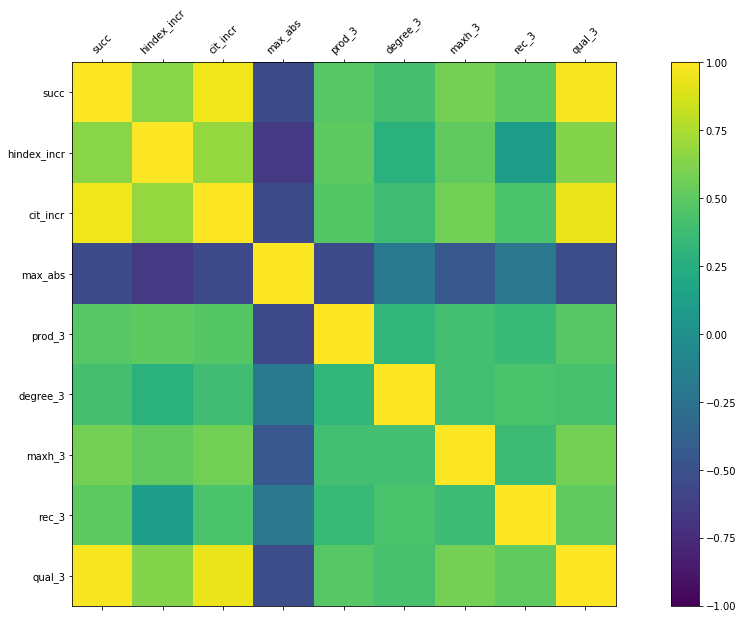

In [13]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(cor_qual, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(col_names_short, rotation=45)
ax.set_yticklabels(col_names_short)
plt.show()

In [14]:
#cor = credible_authors.corr()

In [15]:
#cor_qual[f'h_index_increase_15_{EARLY_CAREER}'].sort_values()

In [16]:
# sns.heatmap(cor, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Linear reg

### Test different predictors

In [17]:
# test different early career lenghts

In [18]:
year = 1995

credible_authors_1991 = credible_authors[credible_authors.start_year == year]

In [19]:
X = credible_authors_1991.copy()

In [20]:
categorical_cols = ['gender']

for col in categorical_cols:
    X = X.join(pd.get_dummies(X[categorical_cols]))

X.drop(categorical_cols, axis=1, inplace=True)

In [21]:
def run_linear(func, name):
    df = pd.DataFrame(columns=['params', f'r_squared_{name}'])
    for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
        for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
            if RECOGNITION_CUT < EARLY_CAREER: continue
            H = X[[
                #'max_absence-0-3', 'avg_absence-0-3',
                   'gender_f', 'gender_m', 'gender_none',
                   f'early_career_degree_{EARLY_CAREER}', 
                   f'early_career_prod_{EARLY_CAREER}',
                   f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
            reg = func.fit(H, y)
            df = df.append({'params': f'EC:{EARLY_CAREER},REC:{RECOGNITION_CUT}',
                            f'r_squared_{name}': reg.score(H, y)}, ignore_index=True)
    return df

In [22]:
def run_cv(func, name, cv, y_col='succ_after_15y'):
    df = pd.DataFrame(columns=['params', f'r_squared_{name}'])
    for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
        for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
            if RECOGNITION_CUT < EARLY_CAREER: continue
            H = X[[
                #'max_absence-0-3', 'avg_absence-0-3',
                   'gender_f', 'gender_m', 'gender_none',
                   f'early_career_degree_{EARLY_CAREER}', 
                   f'early_career_prod_{EARLY_CAREER}',
                   f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
            y = X[y_col]
            score = np.mean(cross_val_score(func, H, y, cv=cv, scoring='r2'))
            df = df.append({'params': f'EC:{EARLY_CAREER},REC:{RECOGNITION_CUT}',
                            f'r_squared_{name}': score}, ignore_index=True)
    return df

In [23]:
df1 = run_cv(LinearRegression(), 'linear', cv=3)

In [24]:
# df1_null = run_cv(LinearRegression(), 'linear_null', cv=3, y_col='succ_shuffled')

In [25]:
df2 = run_cv(ElasticNet(), 'elastic', cv=3)

In [26]:
df3 = run_cv(ElasticNetCV(cv=3), 'elastic_CV', cv=3)

In [27]:
df4 = run_cv(Lasso(alpha=0.1), 'lasso', cv=3)

In [28]:
# Decision tree overfits pretty bad. Maybe GridParam Search?
df5 = run_cv(DecisionTreeRegressor(), 'tree', cv=3)

In [29]:
df6 = run_cv(RandomForestRegressor(), 'forest', cv=3)

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [30]:
# df6_null = run_cv(RandomForestRegressor(), 'forest_null', cv=3, y_col='succ_shuffled')

In [31]:
dfs = [df1, df2, df3, df4, df5, df6] #df1_null, df6_null
for df_ in dfs: df_.set_index('params', inplace=True)

In [32]:
dfs[0].join(dfs[1:])

,r_squared_linear,r_squared_elastic,r_squared_elastic_CV,r_squared_lasso,r_squared_tree,r_squared_forest
params,,,,,,
"EC:3,REC:3",0.37799,0.377128,0.348738,0.378011,-1.332539,0.144151


### Elastic net

In [193]:
# EARLY_CAREER = EARLY_CAREER_LEN_LIST[0]
# RECOGNITION_CUT = RECOGNITION_CUT_OFF_LIST[0]
EARLY_CAREER_LEN_LIST = [3,5,7,9,11,12]
RECOGNITION_CUT_OFF_LIST = [3,5,7,9,11,12]

In [194]:
from sklearn.preprocessing import StandardScaler,RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

In [195]:
dropped_percent = credible_authors.groupby('start_year')['dropped_after_10'].sum() / credible_authors.groupby('start_year')['dropped_after_10'].count()
dropped_percent = dropped_percent.to_frame().T

dropped_percent_agg = credible_authors['dropped_after_10'].sum() / credible_authors['dropped_after_10'].count()

In [234]:
credible_authors_stayed = credible_authors[credible_authors['dropped_after_10'] == False].copy()

In [251]:
# 4 groups of features: productivity, social capital, quality/rec and gender
def make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS, 
                    INCLUDE_VENUE, INCLUDE_YEAR, EARLY_CAREER, RECOGNITION_CUT, dep_var):
    categorical_cols = []
    cols_std = []

    if INCLUDE_YEAR:
        cols_std.append("start_year")
    #scale dependant var
    if dep_var == "dropped_after_10":
        categorical_cols.append(dep_var)
    else:
        cols_std.append(dep_var)

    if INCLUDE_PROD:
        cols_std.append(f'early_career_prod_{EARLY_CAREER}')
        cols_std.append(f'ec_first_auth_{EARLY_CAREER}')

    if INCLUDE_SOCIAL:
        cols_std.append(f'early_career_degree_{EARLY_CAREER}')
        cols_std.append(f'early_career_coauthor_max_hindex_{EARLY_CAREER}')
        cols_std.append(f'team_size_median_{EARLY_CAREER}')
    #     cols_std.append(f'early_career_coauthor_max_cit_{EARLY_CAREER}')

    if INCLUDE_REC:
        cols_std.append(f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}')

    if INCLUDE_QUALITY:
        cols_std.append(f'early_career_qual_{EARLY_CAREER}')
        cols_std.append(f'early_career_qual_first_{EARLY_CAREER}')

    if INCLUDE_GENDER:
        categorical_cols.append('gender')

    if INCLUDE_VENUE:
        cols_std.extend([f'quantiles_bin_{EARLY_CAREER}']) #'deciles_min_3''quantiles_min_3', 'quantiles_bin_3'
    
    return cols_std, categorical_cols #cols_all, 

In [335]:
# TODO we scale data every time we train. Modify to keep data and add remove parameters. Somehow separate the prep from train
def scale_columns(X):
    if len(X.columns) > 0:
        scaler = RobustScaler().fit(X)
#         print(scaler.mean_)
        standardized_cols = scaler.transform(X)
    else: 
        standardized_cols = []
    return pd.DataFrame(standardized_cols, index=X.index, columns=X.columns)

def prepare_data(credible_authors, cols_std, categorical_cols, REMOVE_NONE_AUTHORS):
    X = credible_authors[credible_authors.start_year.isin(COHORT_START_YEARS)].copy()
    
    # Either scale OR INCLUDE start_year as control Var
    # scale dependent variables per year --> WE SHOULD ALSO SCALE OUTCOME VAR
    
#     for year in COHORT_START_YEARS:
#         X.loc[X.start_year == year, cols_std] = scale_columns(X.loc[X.start_year == year, cols_std])

#     scale over whole dataset
#     X[cols_std] = scale_columns(X[cols_std])
    
    # make dummies of categorical cols
    if len(categorical_cols)>0:
        cat_cols = pd.get_dummies(X[categorical_cols]) 
        X = X[cols_std].join(cat_cols)
    else:
        X = X[cols_std]
    if REMOVE_NONE_AUTHORS:
        X.drop('gender_none' , axis=1)
    X['start_year'] = credible_authors['start_year']
    return X

def run_elastic_net_aggr(credible_authors, cols_std, categorical_cols, INCLUDE_YEAR, REMOVE_NONE_AUTHORS, dep_var):
    X = prepare_data(credible_authors, cols_std, categorical_cols, REMOVE_NONE_AUTHORS)
    Y = X[dep_var].copy()
    X = X.drop(dep_var, axis=1)
#     Y = credible_authors[dep_var]
   
    if not INCLUDE_YEAR:
        X = X.drop('start_year' , axis=1)
#     else:
#         # Robust scaler seems to be a poor choice here. Maybe minmax?
#         X['start_year'] = MinMaxScaler().fit_transform(X['start_year'].to_frame())
    
   
    feat_table = run_elastic_net(X, Y)
    feat_table = feat_table.set_index(0)
    
    if dep_var == 'dropped_after_10': 
        feat_table = feat_table.append(pd.DataFrame(index=['drop_percentage'], data=[dropped_percent_agg], columns=[1]))
    return feat_table

def run_elastic_net_cohort(credible_authors, cols_std, categorical_cols, REMOVE_NONE_AUTHORS, dep_var):
    table_list = []
    X = prepare_data(credible_authors, cols_std, categorical_cols, REMOVE_NONE_AUTHORS)
    # REMOVE AFTER TEST!!!!! TODO
    X['ec_prod_4'] = X['early_career_prod_3']*-1 + np.random.normal(0, .1, X.shape[0])
    print(np.corrcoef(X['ec_prod_4'], X['early_career_prod_3']))
    for year in COHORT_START_YEARS:
        X_year = X[X.start_year == year]
#         y_year = credible_authors[credible_authors.start_year == year][dep_var]
        y_year = X_year[dep_var].copy()
        X_year = X_year.drop(dep_var, axis=1)
        print(year, end=' ')
        feat_data = run_elastic_net(X_year.drop('start_year', axis=1), y_year)
        feat_data = feat_data.set_index(0)
        feat_data.rename(index=str, columns={1: year}, inplace=True)
        table_list.append(feat_data)
       
    table = pd.DataFrame(index=table_list[0].index)
    for x in table_list: table=table.join(x)
    if dep_var == 'dropped_after_10': table = table.append(dropped_percent)
    return table

def run_elastic_net(X, y):
    # train model and do cross validation

    # add dummy var if no features are given
    # TODO is this still used?
    if X.empty:
        X = pd.DataFrame(1, index=np.arange(len(y)), columns=["dummy"])
    
    
    if y.nunique()==2:   
        y = y.astype(int)
        #f1, average_precision, roc_auc
        cv_dict = cross_validate(LogisticRegressionCV(cv=10, penalty='l2', max_iter=200), X, y, scoring="average_precision", cv=10, 
                                 return_estimator=True, return_train_score=False)
        net_coef = pd.DataFrame([es.coef_[0] for es in cv_dict['estimator']], columns=X.columns)
#         print(cv_dict)
        score = np.mean(cv_dict['test_score'])
        score2 = None
    else:
        cv_dict = cross_validate(ElasticNetCV(cv=10), X, y, scoring=['r2', 'neg_mean_squared_error'], 
                                 cv=10, return_estimator=True, return_train_score=False)
        net_coef = pd.DataFrame([es.coef_ for es in cv_dict['estimator']], columns=X.columns)
        score = np.mean(cv_dict['test_r2'])
        score2 = np.mean(cv_dict['test_neg_mean_squared_error'])

    # save the intercepts
    net_intercept = np.mean([es.intercept_ for es in cv_dict['estimator']])
    # take the mean and std from coefs
    net_coef_mean = net_coef.mean()
    net_coef_std = net_coef.std()
    rounding = 2
    net_coef_mean_std = list(zip(np.round(net_coef_mean.values,rounding), np.round(net_coef_std.values,rounding)))
    net_coef_mean_std = [f"{x[0]}({x[1]})" for x in net_coef_mean_std]

    cohort_size = len(y)
    #     num_nonzero_coefs = sum(net2.coef_ != 0)
    #     adj_score2 = 1 - (1-score2)*(cohort_size-1)/(cohort_size-num_nonzero_coefs-1)
    if score2:
        net_coef_mean_std.extend([np.round(net_intercept, rounding), np.round(score, rounding), np.round(score2, rounding), cohort_size])
        feat_table = pd.DataFrame(list(zip(np.append(X.columns, ['intercept', 'r2', 'neg_mean_squared_error', 'cohort_size']), net_coef_mean_std)))
    else:
        net_coef_mean_std.extend([np.round(net_intercept, rounding), np.round(score, rounding), cohort_size])
        feat_table = pd.DataFrame(list(zip(np.append(X.columns, ['intercept', 'avg_precision', 'cohort_size']), net_coef_mean_std)))
    return feat_table

In [336]:
# Stuff that we potentially use as outcome Vars
# dv_hindex = 'h-index_15'
# dv_citations = 'succ_after_15y'

dv_hindex_incr = f'h_index_increase_15_{EARLY_CAREER}'
dv_citations_incr = f'citation_increase_15_{EARLY_CAREER}'
dv_dropped = 'dropped_after_10'

DV = dv_hindex_incr

# check if outcome vars are plausible
# #print(credible_authors.columns)
# credible_authors[["start_year", "succ_after_15y"]].groupby("start_year").mean().plot()
# credible_authors[["start_year", "h_index_increase_15_3"]].groupby("start_year").mean().plot()
# credible_authors[["start_year", "citation_increase_15_3"]].groupby("start_year").mean().plot()
# credible_authors[["start_year", "avg_absence-0-15"]].groupby("start_year").mean().plot()
# credible_authors[["start_year", "dropped_after_10"]].groupby("start_year").mean().plot()
# credible_authors[["start_year", "total_num_pub"]].groupby("start_year").mean().plot()
# credible_authors[["start_year", "career_length"]].groupby("start_year").mean().plot()

## Cohort Elastic Net Models
We compare the predictive performance across cohorts. We should plot R2 and F1 over cohorts.
Is predictive performance stable?

In [215]:
def make_result_table(feature_table):
    results = feature_table.transpose()
    #shorten column names
    new_cols = dict(zip(results.columns, [col.replace('early_career', 'ec') for col in results.columns]))

    results.rename(new_cols, axis='columns', inplace=True)
    results.rename({'feature':'cohort','ec_coauthor_max_cit_3': 'ec_coauth_max_cit_3', 'ec_recognition_EC3_RC5':'ec_recog_EC3_RC5'}, axis='columns', inplace=True)
    return results
def results_to_latex(results, name):
    ltx_file = open(f"results_{name}.tex", "w")
    ltx_file.write('\n'.join(results.to_latex().split('\n')[5:-7]))
    ltx_file.write('\hline \n')
    ltx_file.write('\n'.join(results.to_latex().split('\n')[-7:-3]))
    ltx_file.close()

In [283]:
def get_baseline_vars():
    INCLUDE_PROD = 0
    INCLUDE_SOCIAL = 0
    INCLUDE_REC = 0
    INCLUDE_QUALITY = 0
    INCLUDE_GENDER = 0
    REMOVE_NONE_AUTHORS = 0
    INCLUDE_VENUE = 0
    INCLUDE_YEAR = 1
    return INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS,INCLUDE_VENUE,INCLUDE_YEAR
def get_human_cap_vars():
    INCLUDE_PROD = 1
    INCLUDE_SOCIAL = 0
    INCLUDE_REC = 1
    INCLUDE_QUALITY = 0
    INCLUDE_GENDER = 0
    REMOVE_NONE_AUTHORS = 0
    INCLUDE_VENUE = 0
    INCLUDE_YEAR = 1
    return INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS,INCLUDE_VENUE,INCLUDE_YEAR
def get_gender_vars():
    INCLUDE_PROD = 1
    INCLUDE_SOCIAL = 0
    INCLUDE_REC = 1
    INCLUDE_GENDER = 1
    INCLUDE_QUALITY = 0
    REMOVE_NONE_AUTHORS = 0
    INCLUDE_VENUE = 0
    INCLUDE_YEAR = 1
    return INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS,INCLUDE_VENUE,INCLUDE_YEAR
def get_social_vars():
    INCLUDE_PROD = 1
    INCLUDE_SOCIAL = 1
    INCLUDE_REC = 1
    INCLUDE_GENDER = 1
    INCLUDE_QUALITY = 0
    REMOVE_NONE_AUTHORS = 0
    INCLUDE_VENUE = 0
    INCLUDE_YEAR = 1
    return INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS,INCLUDE_VENUE,INCLUDE_YEAR
def get_symbolic_vars():
    INCLUDE_PROD = 1
    INCLUDE_SOCIAL = 1
    INCLUDE_REC = 1
    INCLUDE_GENDER = 1
    INCLUDE_QUALITY = 0
    REMOVE_NONE_AUTHORS = 0
    INCLUDE_VENUE = 1
    INCLUDE_YEAR = 1
    return INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS,INCLUDE_VENUE,INCLUDE_YEAR
def get_full_vars():
    INCLUDE_PROD = 1
    INCLUDE_SOCIAL = 1
    INCLUDE_REC = 1
    INCLUDE_GENDER = 1
    INCLUDE_QUALITY = 1
    REMOVE_NONE_AUTHORS = 0
    INCLUDE_VENUE = 1
    INCLUDE_YEAR = 1
    return INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC, INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS,INCLUDE_VENUE,INCLUDE_YEAR

# Run the elastic net across cohorts
def elastic_cohort(credible_authors, params_func, EARLY_CAREER, RECOGNITION_CUT, DV):
    params = params_func()
    cols_std, categorical_cols = make_cols_lists(*params, EARLY_CAREER, RECOGNITION_CUT, DV)
    print(cols_std)
    REMOVE_NONE_AUTHORS = params[-3]
    res = run_elastic_net_cohort(credible_authors, cols_std, categorical_cols, REMOVE_NONE_AUTHORS, DV)
    res = make_result_table(res)
    return res
def elastic_agg(credible_authors, params_func, EARLY_CAREER, RECOGNITION_CUT, DV):
    params = params_func()
    cols_std, categorical_cols = make_cols_lists(*params, EARLY_CAREER, RECOGNITION_CUT, DV)
    INCLUDE_YEAR = params[-1]
    REMOVE_NONE_AUTHORS = params[-3]
    res_agg = run_elastic_net_aggr(credible_authors, cols_std, categorical_cols, INCLUDE_YEAR, REMOVE_NONE_AUTHORS, DV)
    return res_agg
# Run the elastic net across grouped data, for all variations
def elastic_agg_all(credible_authors, EARLY_CAREER, RECOGNITION_CUT, DV):
    params_func_list = [get_baseline_vars, get_human_cap_vars, get_gender_vars, get_social_vars, get_symbolic_vars, get_full_vars]
    res_agg_list = [elastic_agg(credible_authors, params_func, EARLY_CAREER, RECOGNITION_CUT, DV) for params_func in params_func_list]
    res_all_agg = pd.DataFrame(index=res_agg_list[-1].index, data=[])
    res_all_agg['baseline'] = res_agg_list[0]
    res_all_agg['human'] = res_agg_list[1]
    res_all_agg['gender'] = res_agg_list[2]
    res_all_agg['social'] = res_agg_list[3]
    res_all_agg['symbolic'] = res_agg_list[4]
    res_all_agg['full_model'] = res_agg_list[5]
    if DV == 'dropped_after_10':
        reorderlist = ['start_year', 'early_career_prod_3', 'early_career_recognition_EC3_RC3', 'ec_first_auth_3',
                   'gender_f', 'gender_m', 'gender_none', 
                   'early_career_degree_3', 'early_career_coauthor_max_hindex_3', 'team_size_median_3',
                   'quantiles_bin_3', 'early_career_qual_3', 'early_career_qual_first_3',
                   'cohort_size', 'drop_percentage','avg_precision']
        res_all_agg = res_all_agg.reindex(reorderlist)
        res_all_agg = res_all_agg.fillna('')
        res_all_agg['names'] = ['start year', 'productivity', 'recognition', 'prod first author',
                       'male', 'female', 'none', 
                       'degree', 'coauthor hindex', 'median team size',
                       'top-venue', 'quality', 'quality first author',
                       'cohort size', '% dropouts','Average precision']
    else:
        reorderlist = ['start_year', 'early_career_prod_3', 'early_career_recognition_EC3_RC3', 'ec_first_auth_3',
                   'gender_f', 'gender_m', 'gender_none', 
                   'early_career_degree_3', 'early_career_coauthor_max_hindex_3', 'team_size_median_3',
                   'quantiles_bin_3', 'early_career_qual_3',  'early_career_qual_first_3',
                   'cohort_size', 'neg_mean_squared_error', 'intercept','r2']
        res_all_agg = res_all_agg.reindex(reorderlist)
        res_all_agg = res_all_agg.fillna('')
        res_all_agg['names'] = ['start year', 'productivity', 'recognition', 'prod first author', 
                       'male', 'female', 'none', 
                       'degree', 'coauthor hindex', 'median team size',
                       'top-venue', 'quality', 'quality first author',
                       'cohort size', 'MSE', 'intercept','R2']
    res_all_agg = res_all_agg.set_index('names')
    return res_all_agg
def get_report_from_table(result_table):
    report = []
    for col in result_table.columns[:-4]:
        float_vals = result_table[col].apply(lambda x: float(x.split('(')[0]))
        num_positive = float_vals.gt(0).sum()
        num_neg = float_vals.lt(0).sum()
        report.append({
            "feature": col, 
            'num_positive': num_positive, 
            'num_negative': num_neg,
            'mean': float_vals.mean()})
    return pd.DataFrame(report).set_index('feature')

### Baseline Model

In [205]:
res_cohort_base_hind = elastic_cohort(credible_authors, get_baseline_vars, EARLY_CAREER, RECOGNITION_CUT,
                                      dv_hindex_incr)
# res_cohort_base_cita = elastic_cohort(credible_authors, get_baseline_vars, EARLY_CAREER, RECOGNITION_CUT,
#                                       dv_citations_incr)
# res_cohort_base_drop = elastic_cohort(get_baseline_vars, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)

['start_year', 'h_index_increase_15_3']
1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 

In [206]:
# res_cohort_base_hind

### Human Capital Model

In [337]:
res_cohort_humcap_hind = elastic_cohort(credible_authors, get_human_cap_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_hindex_incr)
# res_cohort_humcap_cita = elastic_cohort(credible_authors, get_human_cap_vars, EARLY_CAREER, RECOGNITION_CUT,
#                                         dv_citations_incr)
# res_cohort_humcap_drop = elastic_cohort(get_human_cap_vars, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)

['start_year', 'h_index_increase_15_3', 'early_career_prod_3', 'ec_first_auth_3', 'early_career_recognition_EC3_RC3']
[[ 1.         -0.99879614]
 [-0.99879614  1.        ]]
1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 

In [ ]:
#no scale
res_cohort_humcap_hind

In [332]:
#robust
res_cohort_humcap_hind

,ec_prod_3,ec_first_auth_3,ec_recognition_EC3_RC3,ec_prod_4,intercept,r2,neg_mean_squared_error,cohort_size
1970,0.28(0.1),-0.03(0.04),-0.03(0.01),-0.1(0.08),0.4,0.22,-0.87,763
1971,0.32(0.07),-0.0(0.01),-0.07(0.01),-0.07(0.06),0.39,0.24,-0.7,981
1972,0.11(0.08),0.01(0.01),-0.04(0.01),-0.33(0.09),0.38,0.3,-0.72,1207
1973,0.2(0.01),0.0(0.0),-0.01(0.03),-0.18(0.01),0.42,0.3,-0.78,1400
1974,0.47(0.04),-0.08(0.01),0.01(0.0),-0.03(0.04),0.26,0.36,-0.7,1830
1975,0.22(0.02),0.0(0.0),0.0(0.0),-0.15(0.01),0.34,0.32,-0.67,1599
1976,0.23(0.03),0.02(0.02),0.03(0.01),-0.2(0.02),0.33,0.29,-0.77,1996
1977,0.41(0.2),-0.02(0.04),0.05(0.01),0.03(0.16),0.48,0.2,-1.18,1929
1978,0.21(0.03),-0.01(0.02),-0.0(0.01),-0.17(0.02),0.41,0.26,-0.8,1907
1979,0.36(0.1),-0.02(0.03),-0.0(0.01),-0.09(0.08),0.43,0.27,-1.07,2352


In [ ]:
#no scale
res_cohort_humcap_hind.apply(lambda x: float(x['ec_prod_3'].split('(')[0])+float(x['ec_prod_4'].split('(')[0]), axis=1)

In [334]:
#robust
res_cohort_humcap_hind.apply(lambda x: float(x['ec_prod_3'].split('(')[0])+float(x['ec_prod_4'].split('(')[0]), axis=1)

1970    0.18
1971    0.25
1972   -0.22
1973    0.02
1974    0.44
1975    0.07
1976    0.03
1977    0.44
1978    0.04
1979    0.27
1980    0.12
1981    0.04
1982    0.05
1983    0.05
1984    0.38
1985    0.37
1986    0.01
1987    0.34
1988    0.37
1989    0.29
1990    0.37
1991    0.33
1992    0.09
1993    0.55
1994    0.68
1995    0.09
1996    0.70
1997    0.57
1998    0.34
1999    0.43
2000    0.47
dtype: float64

In [225]:
r2_old_col = res_cohort_humcap_hind.r2.copy()

### Gender Model

In [ ]:
res_cohort_gender_hind = elastic_cohort(credible_authors, get_gender_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_hindex_incr)
res_cohort_gender_cita = elastic_cohort(credible_authors, get_gender_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_citations_incr)
# res_cohort_gender_drop = elastic_cohort(get_gender_vars, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)

In [46]:
res_cohort_gender_hind

,ec_prod_3,ec_recognition_EC3_RC3,gender_f,gender_m,gender_none,intercept,r2,neg_mean_squared_error,cohort_size
1970,0.43(0.02),0.01(0.0),0.0(0.0),0.0(0.0),0.0(0.0),0.02,0.27,-1.2,763
1971,0.51(0.02),-0.03(0.01),0.03(0.07),-0.03(0.03),0.0(0.0),-0.08,0.28,-0.97,981
1972,0.54(0.01),-0.03(0.01),0.0(0.0),0.0(0.0),0.0(0.0),-0.1,0.32,-1.03,1207
1973,0.51(0.02),-0.0(0.01),0.0(0.0),0.0(0.0),0.0(0.0),-0.04,0.3,-1.25,1400
1974,0.58(0.01),0.01(0.0),0.0(0.0),0.02(0.04),0.0(0.0),-0.24,0.39,-1.09,1830
1975,0.51(0.01),0.01(0.01),0.0(0.0),0.04(0.04),0.0(0.0),-0.14,0.33,-1.14,1599
1976,0.6(0.02),0.04(0.01),0.0(0.0),0.0(0.0),0.0(0.0),-0.2,0.32,-1.36,1996
1977,0.49(0.05),0.04(0.01),0.0(0.0),0.02(0.05),0.0(0.0),0.12,0.22,-2.17,1929
1978,0.58(0.02),-0.0(0.01),-0.23(0.03),0.03(0.02),0.0(0.0),-0.09,0.29,-1.53,1907
1979,0.66(0.02),0.01(0.0),0.0(0.0),0.0(0.0),0.0(0.0),-0.1,0.3,-2.19,2352


### Social Capital Model

In [ ]:
res_cohort_soccap_hind = elastic_cohort(credible_authors, get_social_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_hindex_incr)
res_cohort_soccap_cita = elastic_cohort(credible_authors, get_social_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_citations_incr)
# res_cohort_soccap_drop = elastic_cohort(get_social_vars, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)

In [ ]:
res_cohort_soccap_hind

### Symbolic Capital

In [ ]:
res_cohort_symcap_hind = elastic_cohort(credible_authors, get_symbolic_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_hindex_incr)
res_cohort_symcap_cita = elastic_cohort(credible_authors, get_symbolic_vars, EARLY_CAREER, RECOGNITION_CUT,
                                        dv_citations_incr)
# res_cohort_symcap_drop = elastic_cohort(get_symbolic_vars, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)

In [ ]:
res_cohort_symcap_hind

### Full Model (Extended Human Capital)

In [ ]:
res_cohort_full_hind = elastic_cohort(credible_authors, get_full_vars, EARLY_CAREER, RECOGNITION_CUT, dv_hindex_incr)
res_cohort_full_cita = elastic_cohort(credible_authors, get_full_vars, EARLY_CAREER, RECOGNITION_CUT, dv_citations_incr)

In [ ]:
res_cohort_full_drop = elastic_cohort(credible_authors, get_full_vars, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)
res_cohort_full_drop

In [281]:
get_report_from_table(res_cohort_full_drop)

,mean,num_negative,num_positive
feature,,,
ec_prod_3,-0.773548,31,0
ec_degree_3,0.060000,0,30
ec_coauthor_max_hindex_3,-0.032903,19,6
ec_recognition_EC3_RC3,0.094194,0,31
ec_qual_3,-0.018710,26,0
quantiles_bin_3,-0.418710,31,0
gender_f,0.045806,8,21
gender_m,-0.100645,30,1
gender_none,0.069032,5,24


#### Stayed

In [235]:
#stayed
res_cohort_full_hind_stay = elastic_cohort(credible_authors_stayed, get_full_vars,
                                           EARLY_CAREER, RECOGNITION_CUT, dv_hindex_incr)
res_cohort_full_hind_stay

['start_year', 'h_index_increase_15_3', 'early_career_prod_3', 'ec_first_auth_3', 'early_career_degree_3', 'early_career_coauthor_max_hindex_3', 'team_size_median_3', 'early_career_recognition_EC3_RC3', 'early_career_qual_first_3', 'quantiles_bin_3']
1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 

,ec_prod_3,ec_first_auth_3,ec_degree_3,ec_coauthor_max_hindex_3,team_size_median_3,ec_recognition_EC3_RC3,ec_qual_first_3,quantiles_bin_3,gender_f,gender_m,gender_none,intercept,r2,neg_mean_squared_error,cohort_size
1970,0.26(0.03),-0.23(0.04),0.05(0.03),0.27(0.08),-0.13(0.07),-0.36(0.05),0.1(0.01),0.01(0.02),0.58(0.38),-0.06(0.07),-0.0(0.01),1.3,0.13,-1.86,192
1971,0.15(0.03),-0.0(0.02),0.09(0.01),0.29(0.04),-0.16(0.03),-0.23(0.03),0.05(0.01),0.0(0.0),0.01(0.03),-0.22(0.05),0.01(0.03),1.11,0.23,-1.35,288
1972,0.2(0.03),0.07(0.04),0.13(0.03),0.27(0.05),-0.03(0.03),-0.25(0.02),0.05(0.0),0.0(0.0),0.0(0.0),0.0(0.0),0.04(0.04),0.75,0.26,-1.41,324
1973,0.22(0.02),-0.01(0.03),0.05(0.03),0.06(0.04),-0.01(0.02),-0.18(0.04),0.05(0.0),0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0),0.8,0.28,-1.44,424
1974,0.33(0.02),-0.17(0.03),-0.01(0.01),0.1(0.03),-0.05(0.02),-0.07(0.01),0.03(0.0),0.14(0.05),0.0(0.0),0.02(0.03),-0.01(0.01),0.8,0.29,-1.54,459
1975,0.18(0.02),-0.04(0.04),0.11(0.03),0.19(0.02),-0.12(0.06),-0.09(0.06),0.03(0.01),0.07(0.07),0.0(0.0),0.01(0.02),-0.0(0.01),0.87,0.24,-1.35,481
1976,0.28(0.02),0.01(0.01),0.04(0.02),0.17(0.03),-0.09(0.04),-0.04(0.02),0.02(0.0),0.0(0.0),0.0(0.0),-0.0(0.01),0.01(0.02),0.78,0.25,-1.59,566
1977,0.19(0.03),-0.14(0.03),0.07(0.03),0.13(0.01),-0.15(0.02),-0.05(0.01),0.05(0.0),0.0(0.01),0.0(0.0),-0.0(0.01),0.0(0.0),1.3,0.17,-2,653
1978,0.21(0.02),-0.2(0.03),0.05(0.02),0.17(0.01),-0.14(0.02),-0.11(0.02),0.05(0.0),0.28(0.04),0.0(0.0),-0.0(0.01),0.02(0.02),0.97,0.31,-1.3,588
1979,0.33(0.02),-0.12(0.03),0.06(0.01),0.17(0.02),-0.19(0.03),-0.22(0.01),0.03(0.0),0.02(0.06),-0.0(0.01),0.01(0.03),0.0(0.0),1.2,0.22,-1.93,768


In [237]:
res_cohort_full_cita_stay = elastic_cohort(credible_authors_stayed, get_full_vars, EARLY_CAREER, RECOGNITION_CUT, 
                                           dv_citations_incr)
res_cohort_full_cita_stay

['start_year', 'citation_increase_15_3', 'early_career_prod_3', 'ec_first_auth_3', 'early_career_degree_3', 'early_career_coauthor_max_hindex_3', 'team_size_median_3', 'early_career_recognition_EC3_RC3', 'early_career_qual_first_3', 'quantiles_bin_3']
1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 

,ec_prod_3,ec_first_auth_3,ec_degree_3,ec_coauthor_max_hindex_3,team_size_median_3,ec_recognition_EC3_RC3,ec_qual_first_3,quantiles_bin_3,gender_f,gender_m,gender_none,intercept,r2,neg_mean_squared_error,cohort_size
1970,5.06(0.54),-5.89(0.44),2.54(0.53),5.82(1.13),-3.17(1.07),-4.05(1.09),2.19(0.34),1.88(0.59),1.66(0.75),-0.62(0.86),-0.39(0.38),11.84,0.12,-1348.55,192
1971,5.89(1.15),-0.4(0.41),-0.04(0.39),7.47(2.42),-0.21(0.23),-2.97(0.84),1.93(0.1),-0.0(0.01),1.37(0.72),-2.54(0.84),0.33(0.28),-4.56,0.01,-1089.37,288
1972,4.52(0.69),0.77(0.53),2.86(0.44),5.17(1.32),-0.74(0.38),-2.0(0.53),1.68(0.11),-0.37(0.41),0.13(0.23),-0.12(0.22),0.0(0.0),-2.45,0.31,-900.74,324
1973,2.85(0.55),-0.27(0.46),1.27(0.5),1.34(0.47),-0.07(0.21),-0.37(0.8),2.26(0.13),-0.01(0.02),0.0(0.0),0.0(0.0),0.07(0.17),0.4,0.47,-1026.14,424
1974,5.49(0.42),-0.86(0.49),1.19(0.54),1.71(0.47),-0.77(0.39),0.11(0.24),1.52(0.05),0.0(0.0),0.0(0.0),0.07(0.12),-0.01(0.02),-0.54,0.46,-746.44,459
1975,3.0(0.32),0.14(0.37),3.73(0.8),3.41(0.47),-2.23(0.52),1.62(0.95),1.26(0.24),0.0(0.0),0.0(0.0),0.98(0.26),-0.95(0.23),-0.69,0.4,-763.73,481
1976,5.32(0.73),1.41(0.5),0.82(0.39),4.16(0.78),-0.14(0.18),2.24(0.67),1.2(0.09),-0.52(0.35),0.0(0.0),0.01(0.02),-0.15(0.19),-5.42,0.37,-971.43,566
1977,3.11(0.72),-2.79(0.86),2.49(0.57),2.08(0.26),-3.02(0.76),3.85(0.56),1.45(0.14),-0.41(0.39),1.63(0.73),-1.52(0.77),-0.0(0.0),11.53,0.3,-1528.36,653
1978,4.47(0.45),-2.51(0.39),-0.33(0.2),5.04(0.25),-0.69(0.2),-0.3(0.5),2.07(0.05),0.01(0.04),0.0(0.0),-0.07(0.11),0.06(0.11),0.58,0.37,-607.26,588
1979,6.56(0.61),-2.8(0.69),1.36(0.3),2.88(0.32),-2.88(0.36),-0.79(0.2),1.14(0.05),0.0(0.0),-0.16(0.22),0.13(0.16),0.03(0.08),6.09,0.3,-1415.58,768


#### Plot prediction success over cohorts

In [ ]:
sns.set_palette('deep')

In [ ]:
def plot_metric_over_cohorts(data, criteria, criteria_name, title, letter, filename, legend=False):
    linewidth = 2
    fontsize = 18
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    labels = ['h_index']
    i=0
    ax.plot(data.index, data[criteria], linewidth=linewidth, label=labels[i], color=sns.color_palette()[0])
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    if 'r2' in criteria:
        ax.set_ylim([0.18, 0.65])
    if 'precision' in criteria:
        ax.set_ylim([0.7, 1.05])
    ax.set_xlabel('Cohort year', fontsize=fontsize)
    ax.set_ylabel(f'{criteria_name}', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
    ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
    ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)
    if legend: ax.legend(fontsize=fontsize/2)
    plt.gcf().text(0., 0.9, letter, fontsize=fontsize*2)
    plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
    fig.savefig(f'./fig/{filename}.pdf')

In [ ]:
plot_metric_over_cohorts(res_cohort_full_hind, 'r2', 'R squared', 'H index increase - full', 'A', 'pred_r2_hind_full')
# plot_metric_over_cohorts(res_cohort_sym_hind, 'r2', 'R squared', 'H index increase prediction - symbolic', 'A')
plot_metric_over_cohorts(res_cohort_full_cita, 'r2', 'R squared', 'Citation increase - full', 'B', 'pred_r2_cita_full')
# plot_metric_over_cohorts(res_cohort_full_drop, 'avg_precision', 'Average precision', 'Dropout prediction - full', 'C', 'pred_avgp_drop_full')

## Aggregated Elastic Net Models
We test the effect of different groups of features (human capital, social capital and gender) on success/dropout

In [286]:
elastic_agg_all(credible_authors, EARLY_CAREER, RECOGNITION_CUT, dv_hindex_incr)

,baseline,human,gender,social,symbolic,full_model
names,,,,,,
start year,0.03(0.0),0.02(0.0),0.02(0.0),0.01(0.0),0.01(0.0),0.01(0.0)
productivity,,0.41(0.0),0.41(0.0),0.37(0.0),0.36(0.0),0.35(0.0)
recognition,,0.01(0.0),0.01(0.0),-0.04(0.0),-0.04(0.0),-0.13(0.0)
prod first author,,0.05(0.0),0.04(0.0),0.04(0.0),0.04(0.0),0.02(0.0)
male,,,-0.0(0.01),-0.01(0.01),-0.01(0.01),0.0(0.0)
female,,,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
none,,,0.01(0.01),0.0(0.01),0.0(0.0),0.0(0.0)
degree,,,,0.05(0.0),0.04(0.0),0.04(0.0)
coauthor hindex,,,,0.11(0.0),0.11(0.0),0.1(0.0)


In [236]:
elastic_agg_all(credible_authors_stayed, EARLY_CAREER, RECOGNITION_CUT, dv_hindex_incr)

,baseline,human,gender,social,symbolic,full_model
names,,,,,,
start year,0.05(0.0),0.04(0.0),0.04(0.0),0.03(0.0),0.03(0.0),0.03(0.0)
productivity,,0.31(0.0),0.31(0.0),0.27(0.0),0.27(0.0),0.26(0.0)
recognition,,0.06(0.0),0.06(0.0),0.01(0.0),0.01(0.0),-0.06(0.0)
male,,,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
female,,,-0.01(0.01),0.0(0.0),0.0(0.0),0.0(0.0)
none,,,0.05(0.01),0.03(0.02),0.03(0.01),0.0(0.0)
degree,,,,0.03(0.0),0.03(0.0),0.03(0.0)
coauthor hindex,,,,0.16(0.0),0.16(0.0),0.15(0.0)
median team size,,,,-0.09(0.0),-0.09(0.0),-0.09(0.0)


In [ ]:
elastic_agg_all(credible_authors, EARLY_CAREER, RECOGNITION_CUT, dv_citations_incr)

,baseline,human,gender,social,symbolic,full_model
names,,,,,,
start year,0.81(0.01),0.53(0.01),0.54(0.01),0.43(0.01),0.43(0.01),0.25(0.01)
productivity,,11.24(0.09),11.24(0.09),10.59(0.08),10.62(0.08),6.79(0.06)
recognition,,9.14(0.13),9.14(0.13),8.24(0.14),8.25(0.14),-1.03(0.05)
male,,,-0.19(0.07),-0.27(0.06),-0.3(0.06),0.0(0.0)
female,,,-0.0(0.01),0.0(0.0),0.0(0.0),0.0(0.0)
none,,,0.86(0.18),0.66(0.17),0.69(0.18),0.0(0.0)
degree,,,,-0.33(0.03),-0.27(0.03),0.0(0.0)
coauthor hindex,,,,3.51(0.05),3.53(0.05),1.68(0.03)
median team size,,,,-0.21(0.02),-0.27(0.02),-0.23(0.01)


In [ ]:
elastic_agg_all(credible_authors, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)

/home/danielkostic/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [238]:
elastic_agg_all(credible_authors_stayed, EARLY_CAREER, RECOGNITION_CUT, dv_dropped)

,baseline,human,gender,social,symbolic,full_model
names,,,,,,
start year,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
productivity,,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
recognition,,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
male,,,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
female,,,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
none,,,0.0(0.0),0.0(0.0),0.0(0.0),0.0(0.0)
degree,,,,0.0(0.0),0.0(0.0),0.0(0.0)
coauthor hindex,,,,0.0(0.0),0.0(0.0),0.0(0.0)
median team size,,,,0.0(0.0),0.0(0.0),0.0(0.0)


## Run different configs of the elastic model

#### Test train split 80-20

In [ ]:
def run_elastic_predictions_test_train(cols_all, cols_std, categorical_cols, REMOVE_NONE_AUTHORS, EARLY_CAREER):
    feature_table = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
    feature_table2 = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
    feature_table3 = pd.DataFrame(cols_all, columns=['feature']).set_index('feature')
 
    for year in [1970,1999,2000,2001,2002]:
        credible_authors_year = credible_authors[credible_authors.start_year == year]

        X = credible_authors_year.copy()

        #remove non-gender rows
        if REMOVE_NONE_AUTHORS:
            X = X[X["gender"]!="none"]

        # Make dummy values for categorical columns
        gender_cols = pd.get_dummies(X[categorical_cols])

        #if(not REMOVE_NONE_AUTHORS):
            # drop gender none?
            # this is removing rows gender_none col
            #gender_cols.drop('gender_none', axis=1, inplace=True)

        #standardize cols_std
        if len(cols_std)>0:
            standardized_cols = RobustScaler().fit_transform(X[cols_std])


        # claudia: here we could do a 20:80 split and save 20% for later test

        #combine
        H = pd.DataFrame(standardized_cols, index=X.index, columns=cols_std)
        if INCLUDE_GENDER:
            H = H.join(gender_cols)

        y = X[f'h_index_increase_15_{EARLY_CAREER}']
        y2 = X[f'citation_increase_15_{EARLY_CAREER}']
        y3 = X['dropped_after_10'].astype(int)
        
        f1_dropout_list=[]
        r2_hindex_list=[]
        for i in range(10):
            #dropouts
            X_train, X_test, y_train, y_test = train_test_split(H, y3, test_size=0.2)
            rgs = LogisticRegressionCV(cv=3) #, penalty='l2', solver='liblinear'
            #rgs = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
            #           early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
            #           l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
            #           n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
            #           power_t=0.5, random_state=None, shuffle=True, tol=0.001,
            #           validation_fraction=0.1, verbose=0, warm_start=False)
        
            rgs.fit(X_train, y_train)
            f1_dropout = f1_score(y_test, rgs.predict(X_test))
            f1_dropout_list.append(f1_dropout)
            
            #h-index increase
            X_train, X_test, y_train, y_test = train_test_split(H, y, test_size=0.2)
            rgs = ElasticNetCV(cv=3)
            #rgs = ElasticNetCV(cv=3, random_state=1000, max_iter=10000,
            #       alphas=[1.0], l1_ratio=0.5)
            rgs.fit(X_train, y_train)
            r2_hindex = r2_score(y_test, rgs.predict(X_test))
            print(rgs.alpha_)
            r2_hindex_list.append(r2_hindex)
            
        print(f"Year: {year}, f1_dropout: {np.mean(f1_dropout_list)}")
        print(f"Year: {year}, r2_hindex: {np.mean(r2_hindex_list)}")

In [ ]:
INCLUDE_PROD = 1
INCLUDE_SOCIAL = 1
INCLUDE_REC = 1
INCLUDE_GENDER = 1
INCLUDE_QUALITY = 1
REMOVE_NONE_AUTHORS = 0
cols_all, cols_std, categorical_cols = make_cols_lists(INCLUDE_PROD, INCLUDE_SOCIAL, INCLUDE_REC,
                                                       INCLUDE_QUALITY, INCLUDE_GENDER, REMOVE_NONE_AUTHORS, EARLY_CAREER, RECOGNITION_CUT)
run_elastic_predictions_test_train(cols_all, cols_std, categorical_cols, REMOVE_NONE_AUTHORS, EARLY_CAREER)

#### Test predictive power over different number of observed years

In [44]:
EARLY_CAREER_LEN_LIST_EXT = [3,5,7,9,11,12]
RECOGNITION_CUT_OFF_LIST_EXT = [3,5,7,9,11,12]

In [45]:
dv_citations_incr

'citation_increase_15_3'

In [ ]:
def get_r2_increase(COHORT_START_YEARS, EARLY_CAREER_LEN_LIST_EXT, RECOGNITION_CUT_OFF_LIST_EXT, DV):
    r2_increase = pd.DataFrame(index=COHORT_START_YEARS)
    for EARLY_CAREER, RECOGNITION_CUT in zip(EARLY_CAREER_LEN_LIST_EXT, RECOGNITION_CUT_OFF_LIST_EXT):
        print(f'{EARLY_CAREER}, {RECOGNITION_CUT}')
        DV_ = f'{DV}_15_{EARLY_CAREER}'
        print(DV_)
        r2_increase[f'{DV}_{EARLY_CAREER}_{RECOGNITION_CUT}'] = elastic_cohort(credible_authors, get_full_vars,
                                                                               EARLY_CAREER, RECOGNITION_CUT, DV_)['r2']
    return r2_increase
r2_increase_cit = get_r2_increase(COHORT_START_YEARS, EARLY_CAREER_LEN_LIST_EXT, RECOGNITION_CUT_OFF_LIST_EXT, 'citation_increase')
r2_increase_hind = get_r2_increase(COHORT_START_YEARS, EARLY_CAREER_LEN_LIST_EXT, RECOGNITION_CUT_OFF_LIST_EXT, 'h_index_increase')

In [ ]:
r2_increase_hind.mean()

In [ ]:
linewidth = 2
fontsize = 18
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

ax.plot([3,5,7,9,11,12], r2_increase_cit.mean().values, label='citation inc.')
ax.plot([3,5,7,9,11,12], r2_increase_hind.mean().values, label='h-index inc.')

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_xticks([3,5,7,9,11])

ax.set_xlabel('Number of observed years', fontsize=fontsize)
ax.set_ylabel('Avg. R2 over cohorts', fontsize=fontsize)
ax.set_title("Prediction R2 vs observed years", fontsize=fontsize)
ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
ax.spines['left'].set_linewidth(linewidth)
ax.spines['right'].set_linewidth(linewidth)
ax.spines['bottom'].set_linewidth(linewidth)
ax.spines['top'].set_linewidth(linewidth)
ax.legend(fontsize=fontsize/1.5)
plt.gcf().text(0., 0.9, 'D', fontsize=fontsize*2)
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
plt.savefig('./fig/pred_r2_obs_years.pdf')

#### Test predictive power over different number of years being predicted

In [35]:
EARLY_CAREER_LEN_LIST_EXT = [3,5,7,9,11,12]
RECOGNITION_CUT_OFF_LIST_EXT = [3,5,7,9,11,12]

In [ ]:
def get_r2_increase_(COHORT_START_YEARS, EARLY_CAREER_LEN_LIST_EXT, RECOGNITION_CUT_OFF_LIST_EXT, DV):
    r2_increase = pd.DataFrame(index=COHORT_START_YEARS)
    for EARLY_CAREER, RECOGNITION_CUT in zip(EARLY_CAREER_LEN_LIST_EXT[1:], RECOGNITION_CUT_OFF_LIST_EXT[1:]):
        print(f'{EARLY_CAREER}, {RECOGNITION_CUT}')
        DV_ = f'{DV}_{EARLY_CAREER}_3'
        print(DV_)
        r2_increase[f'{DV}_{EARLY_CAREER}_3'] = elastic_cohort(credible_authors, get_full_vars, 3, 3, DV_)['r2']
    return r2_increase
r2_increase_cit_pred = get_r2_increase_(COHORT_START_YEARS, EARLY_CAREER_LEN_LIST_EXT, RECOGNITION_CUT_OFF_LIST_EXT, 'citation_increase')
r2_increase_hind_pred = get_r2_increase_(COHORT_START_YEARS, EARLY_CAREER_LEN_LIST_EXT, RECOGNITION_CUT_OFF_LIST_EXT, 'h_index_increase')

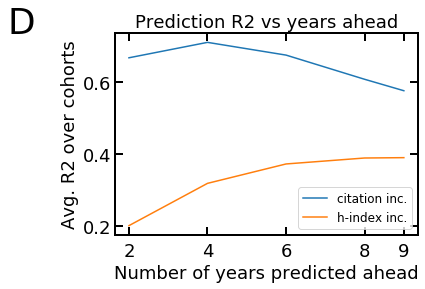

In [43]:
linewidth = 2
fontsize = 18
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

ax.plot([2,4,6,8,9], r2_increase_cit_pred.mean().values, label='citation inc.')
ax.plot([2,4,6,8,9], r2_increase_hind_pred.mean().values, label='h-index inc.')

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
ax.set_xticks([2,4,6,8,9])

ax.set_xlabel('Number of years predicted ahead', fontsize=fontsize)
ax.set_ylabel('Avg. R2 over cohorts', fontsize=fontsize)
ax.set_title("Prediction R2 vs years ahead", fontsize=fontsize)
ax.tick_params(axis="x", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize, pad=7)
ax.tick_params(axis="x", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize, pad=7)
ax.tick_params(axis="y", which='major', direction="in", width=linewidth, size=4*linewidth, labelsize=fontsize)
ax.tick_params(axis="y", which='minor', direction="in", width=linewidth, size=2*linewidth, labelsize=fontsize)
ax.spines['left'].set_linewidth(linewidth)
ax.spines['right'].set_linewidth(linewidth)
ax.spines['bottom'].set_linewidth(linewidth)
ax.spines['top'].set_linewidth(linewidth)
ax.legend(fontsize=fontsize/1.5)
plt.gcf().text(0., 0.9, 'D', fontsize=fontsize*2)
plt.subplots_adjust(left=0.25, right=0.95, bottom=0.2, top=0.9)
plt.savefig('./fig/pred_r2_per_years.pdf')

In [ ]:
stop

#### predictor diffs

In [ ]:
h_index = res_cohort_full_hind
citations = res_cohort_full_cita

In [ ]:
plt.plot(h_index['r2'], label='Increase H index')
plt.plot(citations['r2'], label='Increase Citations')
print("Average difference in r squared", sum(citations['r2']-h_index['r2'])/len(h_index['r2']))
# quality was used as a feature!
plt.legend()
plt.show()

#### gender diffs

In [ ]:
# gender coefs
plt.plot(res_cohort_full_hind['gender_m'], label="Male")
plt.plot(res_cohort_full_hind['gender_f'], label="Female")
plt.legend()
plt.show()

In [ ]:
plt.plot(res_cohort_full_hind['gender_m'] - res_cohort_full_hind['gender_f'], label="Male-Female diff")
plt.plot(res_cohort_full_hind.index ,np.zeros(len(res_cohort_full_hind)))
plt.legend()
plt.show()

#### cohort size diffs

In [ ]:
fig, ax1 = plt.subplots()
# ax1.plot(results['r2'], label='r2')
ax1.plot(res_cohort_full_hind['r2'], label='adjusted r2', color='C2')
ax1.set_ylim([0,1])
ax1.set_xlabel('Years')
ax1.set_ylabel('R squared', color='C2')
ax1.legend(loc=2)

ax2 = ax1.twinx()
ax2.plot(res_cohort_full_hind['cohort_size'], label='Cohort size', color='C3')
ax2.set_ylabel('Cohort size', color='C3')
ax2.legend(loc=4)
plt.show()

#### cheating diffs

In [ ]:
no_cheating = feature_table2.transpose().copy()

In [ ]:
cheat_RC5 = feature_table2.transpose().copy()

In [ ]:
cheat_quality = feature_table2.transpose().copy()

In [ ]:
# How does removing the quality affect the r squared?
plt.plot(with_quality['adj_r2'], label='With quality')
plt.plot(cheat_RC5['adj_r2'], label='With recognition year 5')
plt.plot(no_cheating['adj_r2'], label='No cheating')
print("Average difference in r squared", sum(with_quality['adj_r2']-no_cheating['adj_r2'])/len(cheat_quality))
print(np.mean)
plt.legend()
plt.show()

avg = sum(cheat_quality['adj_r2']-no_cheating['adj_r2'])/len(no_cheating)
plt.plot(cheat_quality['adj_r2']-no_cheating['adj_r2'], label='Difference')
plt.plot(no_cheating.index, [avg]*len(no_cheating), label='Average diff')
plt.title("Difference between quality(15y) and recognition(3y)")
plt.legend()
plt.show()

#### scaler diffs

In [ ]:
std_scaler = feature_table2.transpose().copy()

In [ ]:
rob_scaler = feature_table2.transpose().copy()

In [ ]:
# How does changing the scaler affect the r squared?
plt.plot(std_scaler['adj_r2'], label='Std')
plt.plot(rob_scaler['adj_r2'], label='Rob')
print("Average difference in r squared", sum(std_scaler['adj_r2']-rob_scaler['adj_r2'])/len(rob_scaler))
plt.legend()
plt.show()
# almost no difference

avg = sum(std_scaler['adj_r2']-rob_scaler['adj_r2'])/len(std_scaler)
plt.plot(std_scaler['adj_r2']-rob_scaler['adj_r2'], label='Difference')
plt.plot(std_scaler.index, [avg]*len(std_scaler), label='Average diff')
plt.legend()
plt.show()

In [ ]:
# feature_table3.transpose()

### Best feature selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE, RFECV
from collections import defaultdict

In [ ]:
def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_regression, k=k)
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_regression, k=k)
        col_name = "Mutual Information"
    
    feat_selector = feat_selector.fit(data_frame, target)
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.columns
    
    return feat_scores 

def get_features_rfe(data_frame, target, model,k=5):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame
    y = target
    selector = RFE(model, k, step=1)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return df

def get_features_rfecv(data_frame, target, model, cv=3):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame
    y = target
    selector = RFECV(model, step=1, cv=cv)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return df

In [ ]:
years = credible_authors.start_year.unique()
years = sorted(years)

In [ ]:
df = credible_authors.copy()

In [ ]:
categorical_cols = ['gender']

for col in categorical_cols:
    df = df.join(pd.get_dummies(df[categorical_cols]))

df.drop(categorical_cols, axis=1, inplace=True)

#### Show k best - F regression or mutual information

In [ ]:
linear = True
# true - fregression
# false - mutual info

In [ ]:
params = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[['max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params.append(show_kbest(X_year, y_year, linear, 5))

In [ ]:
params[0]

In [ ]:
selected_f = defaultdict(int)
for param in params:
    selected = param[param.Support == True]['Attribute'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

#### RFE

In [ ]:
params_rfe = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[[
        #'max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params_rfe.append(get_features_rfe(X_year, y_year, LinearRegression(),k=5))

In [ ]:
selected_f = defaultdict(int)
for param in params_rfe:
    selected = param[param.support == True]['feature'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

#### RFE CV

In [ ]:
params_rfecv = []
for year in years:
    df_year = df[df.start_year == year]
    df_year = df_year.drop('start_year', axis=1)
#     for EARLY_CAREER in EARLY_CAREER_LEN_LIST:
#         for RECOGNITION_CUT in RECOGNITION_CUT_OFF_LIST:
#             if RECOGNITION_CUT < EARLY_CAREER: continue
    EARLY_CAREER = 3
    RECOGNITION_CUT= 5
    X_year = df_year[['max_absence-0-3', 'avg_absence-0-3', 
           'gender_f', 'gender_m', 'gender_none',
           f'early_career_degree_{EARLY_CAREER}', 
           f'early_career_prod_{EARLY_CAREER}',
           f'early_career_qual_{EARLY_CAREER}', f'early_career_recognition_EC{EARLY_CAREER}_RC{RECOGNITION_CUT}']]
    y_year = df_year['succ_after_15y']
    params_rfecv.append(get_features_rfecv(X_year, y_year, LinearRegression(),cv=3))

In [ ]:
selected_f = defaultdict(int)
for param in params_rfecv:
    selected = param[param.support == True]['feature'].values
    selected_f['total'] += 1
#     print(selected)
    for select in selected:
        selected_f[select] += 1

In [ ]:
selected_f

### Null experiment

In [ ]:
citations_per_year = pd.read_csv('derived-data/paper-citation-count.csv', header=None, names=['pub_id', 'cit_count'])

In [ ]:
publications = pd.read_csv('derived-data/author-publications.csv')

In [ ]:
# publications.sort_values(by='author').head()

In [ ]:
# remove authors by career_len, and add start year
publications = publications.merge(credible_authors[['author', 'start_year']], on='author')

In [ ]:
publications = publications[publications.year <= publications.year + MAX_CAREER_LEN]

In [ ]:
# citations_per_year.head()

In [ ]:
publications['pub_id'] = shuffle(publications['pub_id']).reset_index(drop=True)

In [ ]:
# publications.sort_values(by='author').head()

In [ ]:
publications = publications.merge(citations_per_year, on='pub_id', how='left')
publications = publications.fillna(0)

In [ ]:
publications.sort_values(by='author').head(20)

In [ ]:
credible_authors[credible_authors.author == "a min tjoa"]['succ_after_15y']

In [ ]:
credible_authors.set_index('author', inplace=True)

In [ ]:
credible_authors['succ_shuffled'] = publications.groupby('author')['cit_count'].sum()

In [ ]:
credible_authors[['succ_shuffled', 'succ_after_15y']].head()

In [ ]:
credible_authors.columns